## Compare PR350 attitude states to flight states and telemetry

This computes attitude states using test (PR-350) and flight code, and then compares to 
telemetry.

**In all cases the new test code matches telemetry as well as flight, and usually much
better.**

In [1]:
import subprocess

# Put git repo code into path
import sys

sys.path.insert(0, "../../")

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from cheta import fetch_eng
from cxotime import CxoTime
from Quaternion import Quat
from ska_matplotlib import plot_cxctime

import kadi
import kadi.commands.states as kcs

matplotlib.style.use("bmh")

print(kadi.__version__)

7.16.1.dev31+gc737281.d20250527


In [2]:
start, stop = "2025:001", "2025:060"
state_keys = [
    "pitch",
    "pcad_mode",
    "off_nom_roll",
    "ra",
    "dec",
    "roll",
    "q1",
    "q2",
    "q3",
    "q4",
]

#### Get states from flight code using a little script

In [3]:
script = f"""
import sys
import kadi.commands.states as kcs
sts = kcs.get_states({start!r}, {stop!r}, state_keys={state_keys!r})
del sts['trans_keys']
sts.write(sys.stdout, format='ascii.ecsv')
"""

proc = subprocess.run(["python", "-c", script], check=True, capture_output=True)

# Read the states
states_flight = Table.read(proc.stdout.decode("utf-8"), format="ascii.ecsv")

#### Get same states using test code

In [4]:
states_test = kcs.get_states(start, stop, state_keys=state_keys)

In [5]:
# Interpolate the states to a common time grid once per minute
times = np.arange(states_test["tstop"][0], states_test["tstop"][-2], 4.1)
states_test_i = kcs.interpolate_states(states_test, times)
states_flight_i = kcs.interpolate_states(states_flight, times)

#### Get pitch, off_nom_roll, AOATTQT<N> from telemetry and interpolate to same time grid

In [6]:
pitch_tlm = fetch_eng.Msid("pitch", start, stop)
pitch_tlm.interpolate(times=times)
off_nom_roll_tlm = fetch_eng.Msid("roll", start, stop)
off_nom_roll_tlm.interpolate(times=times)
q_att_tlm = fetch_eng.Msid("quat_aoattqt", start, stop)
q_att_tlm.interpolate(times=times)

In [7]:
# PCAD mode should be exactly the same for test and flight
assert np.all(states_test_i["pcad_mode"] == states_flight_i["pcad_mode"])  # noqa: S101
npnt: np.ndarray = states_test_i["pcad_mode"] == "NPNT"
nman: np.ndarray = states_test_i["pcad_mode"] == "NMAN"

In [8]:
# Times for a representative maneuver
start_manvr = "2025:001:08:30:00"
stop_manvr = "2025:001:09:30:00"
manvr = (times > CxoTime(start_manvr).secs) & (times < CxoTime(stop_manvr).secs)

### Attitude (e.g. Dec) matches telemetry much better

The current flight code has the state attitude value (Q1-4, RA, Dec, Roll) matching
telemetry at the beginning of the state. The new (test) code matches at state interval
center.

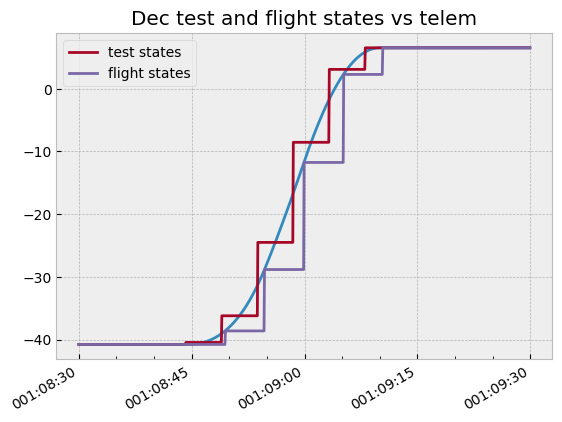

In [9]:
plot_cxctime(times[manvr], q_att_tlm.vals.dec[manvr])
plot_cxctime(times[manvr], states_test_i["dec"][manvr], label="test states")
plot_cxctime(times[manvr], states_flight_i["dec"][manvr], label="flight states")
plt.legend()
plt.title("Dec test and flight states vs telem");

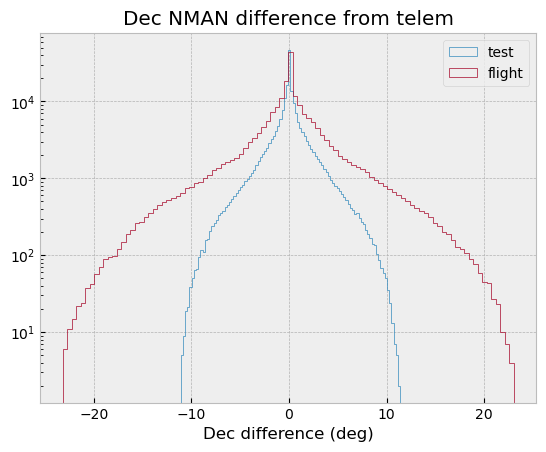

In [10]:
d_dec_test = states_test_i["dec"][nman] - q_att_tlm.vals.dec[nman]
plt.hist(d_dec_test, bins=100, histtype="step", label="test", log=True)

d_dec_flight = states_flight_i["dec"][nman] - q_att_tlm.vals.dec[nman]
plt.hist(d_dec_flight, bins=100, histtype="step", label="flight", log=True)
plt.legend()
plt.xlabel("Dec difference (deg)")
plt.title("Dec NMAN difference from telem");

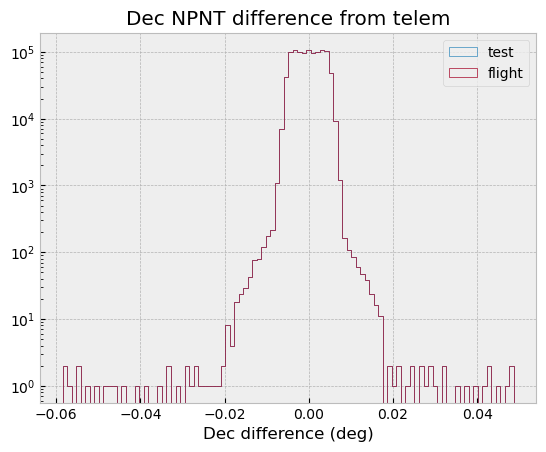

In [11]:
# No substantial diff between test and flight states in NPNT
d_dec_test = states_test_i["dec"][npnt] - q_att_tlm.vals.dec[npnt]
plt.hist(d_dec_test, bins=100, histtype="step", label="test", log=True)

d_dec_flight = states_flight_i["dec"][npnt] - q_att_tlm.vals.dec[npnt]
plt.hist(d_dec_flight, bins=100, histtype="step", label="flight", log=True)
plt.legend()
plt.xlabel("Dec difference (deg)")
plt.title("Dec NPNT difference from telem");

### Compare pitch visually for one maneuver

Flight code does a hack to make the pitch, off_nom_roll more closely (but not exactly) align at the
bin center. 

In the new test code, the pitch matches telemetry at exactly the bin centers.

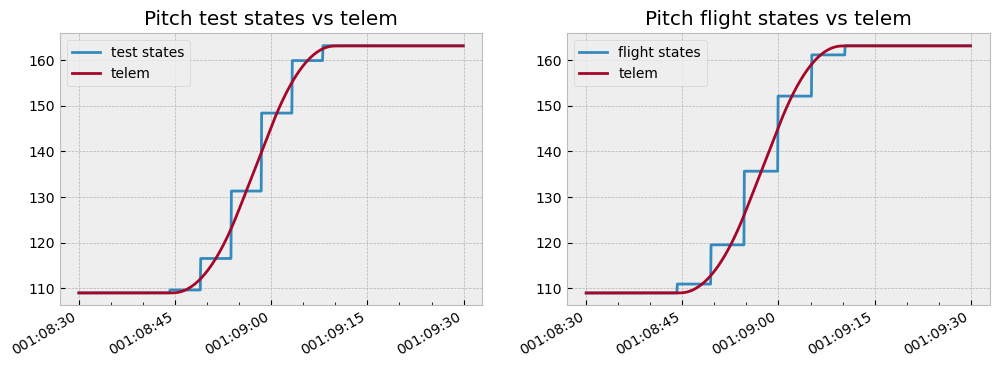

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_cxctime(times[manvr], states_test_i["pitch"][manvr], label="test states", ax=ax[0])
plot_cxctime(times[manvr], pitch_tlm.vals[manvr], label="telem", ax=ax[0])
ax[0].legend()
ax[0].set_title("Pitch test states vs telem")
plot_cxctime(
    times[manvr], states_flight_i["pitch"][manvr], label="flight states", ax=ax[1]
)
plot_cxctime(times[manvr], pitch_tlm.vals[manvr], label="telem", ax=ax[1])
ax[1].legend()
ax[1].set_title("Pitch flight states vs telem");

#### Plot diff between states pitch (test, flight) and telemetry pitch for NPNT intervals

In [13]:
dp_test = states_test_i["pitch"] - pitch_tlm.vals
dp_flight = states_flight_i["pitch"] - pitch_tlm.vals
dr_test = states_test_i["off_nom_roll"] - off_nom_roll_tlm.vals
dr_flight = states_flight_i["off_nom_roll"] - off_nom_roll_tlm.vals

In [14]:
def plot_pitch_roll(dp_test, dp_flight, axis):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(
        dp_test[npnt], bins=100, log=True, histtype="step", label="test", lw=10
    )
    axes[0].hist(
        dp_flight[npnt], bins=100, log=True, histtype="step", label="flight", lw=4
    )
    axes[0].legend()
    axes[0].set_title(f"Delta {axis} NPNT")
    axes[0].set_xlabel(f"Delta {axis} (deg)")

    axes[1].hist(dp_test[nman], bins=100, log=True, histtype="step", label="test")
    axes[1].hist(dp_flight[nman], bins=100, log=True, histtype="step", label="flight")
    axes[1].legend()
    axes[1].set_title(f"Delta {axis} NMAN")
    axes[1].set_xlabel(f"Delta {axis} (deg)")

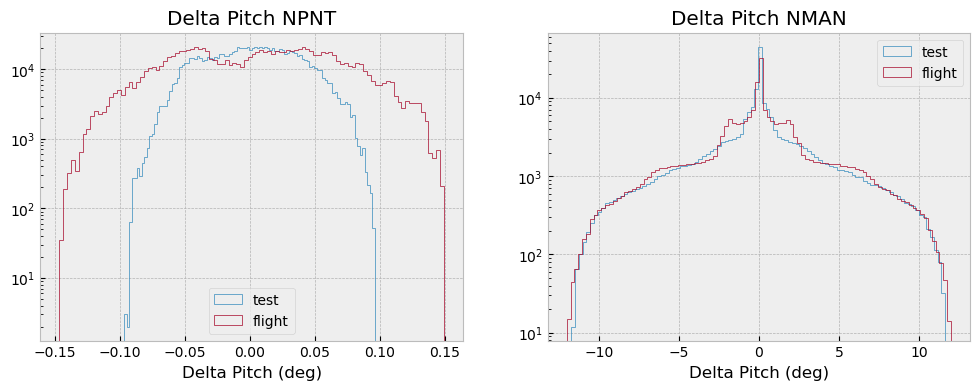

In [15]:
plot_pitch_roll(dp_test, dp_flight, "Pitch")

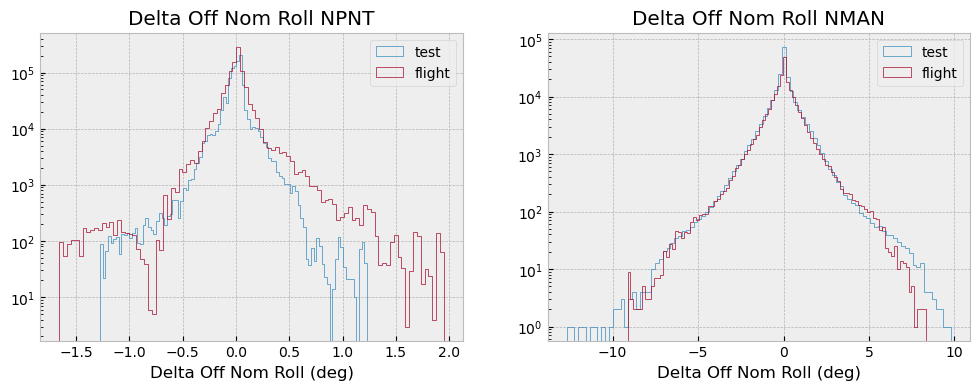

In [16]:
plot_pitch_roll(dr_test, dr_flight, "Off Nom Roll")

In [17]:
q_att_test_eq = Quat(
    equatorial=np.array(
        [states_test_i["ra"], states_test_i["dec"], states_test_i["roll"]]
    ).T
)
q_att_flight_eq = Quat(
    equatorial=np.array(
        [states_flight_i["ra"], states_flight_i["dec"], states_flight_i["roll"]]
    ).T
)

In [18]:
q_att_test_q = Quat(
    q=np.array(
        [
            states_test_i["q1"],
            states_test_i["q2"],
            states_test_i["q3"],
            states_test_i["q4"],
        ]
    ).T
)
q_att_flight_q = Quat(
    q=np.array(
        [
            states_flight_i["q1"],
            states_flight_i["q2"],
            states_flight_i["q3"],
            states_flight_i["q4"],
        ]
    ).T
)

In [19]:
import scipy.linalg

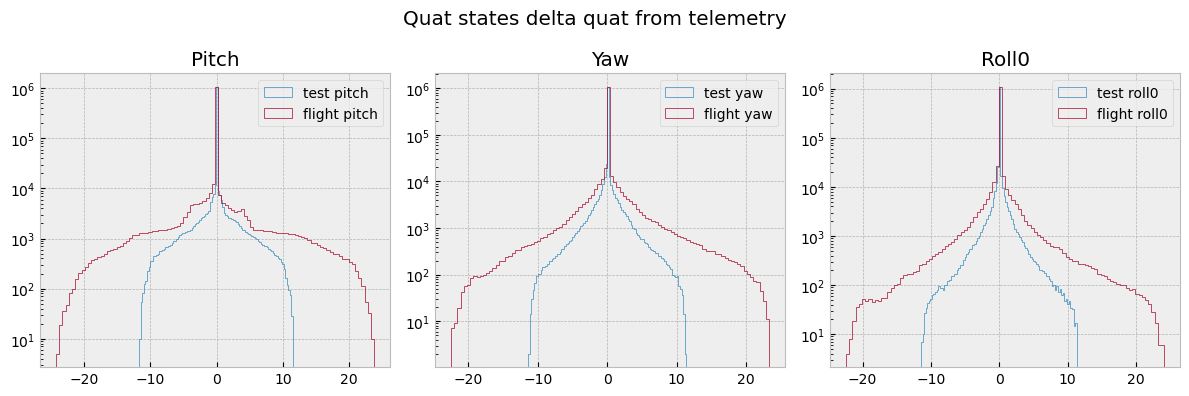

In [20]:
dqt = q_att_test_eq.dq(q_att_tlm.vals)
dqf = q_att_flight_eq.dq(q_att_tlm.vals)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, attr in zip(axes, ["pitch", "yaw", "roll0"]):
    ax.hist(
        getattr(dqt, attr), bins=100, histtype="step", label=f"test {attr}", log=True
    )
    ax.hist(
        getattr(dqf, attr), bins=100, histtype="step", label=f"flight {attr}", log=True
    )
    ax.legend()
    ax.set_title(attr.capitalize())

fig.suptitle("Quat states delta quat from telemetry", fontsize="x-large")
plt.tight_layout()

### Equatorial `ra`, `dec`, `roll` match `q1`, `q2`, `q3`, `q4` to high accuracy

Check for consistency of Quaternion and Equatorial representations of attitude for both
flight and test.

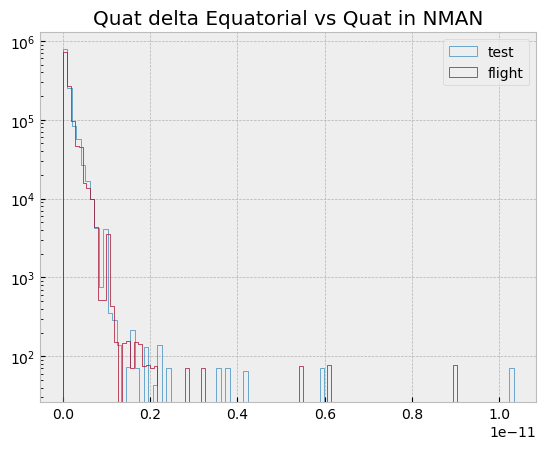

In [21]:
dq = q_att_test_eq.dq(q_att_test_q)
norm = scipy.linalg.norm(dq.q[:, 0:3], axis=1)
plt.hist(norm, bins=100, histtype="step", label="test", log=True)

dq = q_att_flight_eq.dq(q_att_flight_q)
norm = scipy.linalg.norm(dq.q[:, 0:3], axis=1)
plt.hist(norm, bins=100, histtype="step", label="flight", log=True)

plt.legend()
plt.title("Quat delta Equatorial vs Quat in NMAN");